In [1]:
from heeps.pupil.create_petal import create_petal
from heeps.util.img_processing import resize_cube, resize_img, crop_img
from heeps.util.freq_decomp import conv_kernel, spatial
from heeps.util.multiCPU import multiCPU
from scipy.interpolate import interp2d,RectBivariateSpline, griddata
from astropy.io import fits
import os.path
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy
def zoomWithMissingData(data, newSize,
                        method='linear',
                        non_valid_value=numpy.nan):
    '''
    Zoom 2-dimensional or 3D arrays using griddata interpolation.
    This allows interpolation over unstructured data, e.g. interpolating values
    inside a pupil but excluding everything outside.
    See also DM.CustomShapes.

    Note that it can be time consuming, particularly on 3D data

    Parameters
    ----------
    data : ndArray
        2d or 3d array. If 3d array, interpolate by slices of the first dim.
    newSize : tuple
        2 value for the new array (or new slices) size.
    method: str
        'linear', 'cubic', 'nearest'
    non_valid_value: float
        typically, NaN or 0. value in the array that are not valid for the
        interpolation.

    Returns
    -------
    arr : ndarray
        of dimension (newSize[0], newSize[1]) or
        (data.shape[0], newSize[0], newSize[1])
    '''
    if len(data.shape) == 3:
        arr = data[0, :, :]
    else:
        assert len(data.shape) == 2
        arr = data

    Nx = arr.shape[0]
    Ny = arr.shape[1]
    coordX = (numpy.arange(Nx) - Nx / 2. + 0.5) / (Nx / 2.)
    coordY = (numpy.arange(Ny) - Ny / 2. + 0.5) / (Ny / 2.)
    Nx = newSize[0]
    Ny = newSize[1]
    ncoordX = (numpy.arange(Nx) - Nx / 2. + 0.5) / (Nx / 2.)
    ncoordY = (numpy.arange(Ny) - Ny / 2. + 0.5) / (Ny / 2.)

    x, y = numpy.meshgrid(coordX, coordY)
    xnew, ynew = numpy.meshgrid(ncoordX, ncoordY)

    if len(data.shape) == 2:
        idx = ~(arr == non_valid_value)
        znew = griddata((x[idx], y[idx]), arr[idx], (xnew, ynew),
                        method=method)
        return znew
    elif len(data.shape) == 3:
        narr = numpy.zeros((data.shape[0], newSize[0], newSize[1]))
        for i in range(data.shape[0]):
            arr = data[i, :, :]
            idx = ~(arr == non_valid_value)
            znew = griddata((x[idx], y[idx]), arr[idx], (xnew, ynew),
                            method=method)
            narr[i, :, :] = znew
        return narr
#--------------------------------------------------#

# Load c-basic raw data

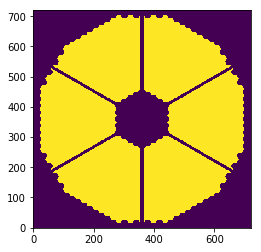

In [3]:
nimg = 720
#folder = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v2_2021-02-18'
folder = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30'
#folder = '~/heeps_metis/input_files/wavefront/scao_petal_piston/cbasic_v1_2020-11-30'
mask = np.float32(fits.getdata(os.path.join(folder, 'Telescope_Pupil.fits')))
mask = crop_img(mask, nimg)
mask = np.rot90(mask)
plt.imshow(mask, origin=True);

data piston (nm) = 1801.4716
data rms (nm) = 116.93555


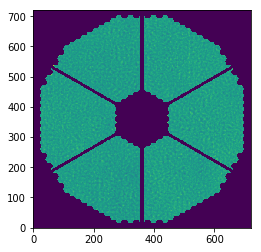

In [4]:
data = np.float32(fits.getdata(os.path.join(folder, 'Residual_phase_screen_2101ms.fits')))
data = crop_img(data, nimg)
data = np.rot90(data) * 1e3        # rotate, convert to nanometers
data[mask==0] = 0
print('data piston (nm) = %s\ndata rms (nm) = %s'%(np.mean(data[mask!=0]), np.std(data[mask!=0])))
plt.imshow(data, origin=True);

### remove frame piston

In [5]:
data -= np.mean(data[mask!=0])
data[mask==0] = 0
print('data piston (nm) = %s\ndata rms (nm) = %s'%(np.mean(data[mask!=0]), np.std(data[mask!=0])))

data piston (nm) = 0.0002272726
data rms (nm) = 116.93555


### calculate petal pistons

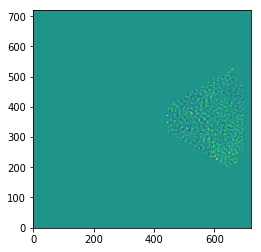

In [6]:
npetals = 6
petals = np.array([create_petal(x, npetals, nimg) for x in range(npetals)])
data_petals = data*petals
plt.imshow(data_petals[0], origin=True);

In [7]:
masked_petals = np.array([data_petals[x][data_petals[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.mean(petal), np.std(petal)))

petal piston (nm) = 21.993607 ; petal rms (nm) = 118.32676
petal piston (nm) = 7.6754103 ; petal rms (nm) = 112.62345
petal piston (nm) = -20.418915 ; petal rms (nm) = 113.43365
petal piston (nm) = 5.443414 ; petal rms (nm) = 115.68831
petal piston (nm) = -29.420332 ; petal rms (nm) = 116.8172
petal piston (nm) = 14.713904 ; petal rms (nm) = 115.71301


# Resize with skimage (currently in HEEPS)

In [8]:
npupil = 285
petals_res = np.float32([create_petal(x, npetals, npupil) for x in range(npetals)])
data_res_petals = petals_res*resize_img(data, npupil)
masked_petals = np.array([data_res_petals[x][data_res_petals[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.mean(petal), np.std(petal)))
data_res_petals.shape

petal piston (nm) = 20.18367 ; petal rms (nm) = 94.12751
petal piston (nm) = 7.070539 ; petal rms (nm) = 89.01941
petal piston (nm) = -18.91746 ; petal rms (nm) = 89.529816
petal piston (nm) = 5.0617557 ; petal rms (nm) = 90.460526
petal piston (nm) = -27.170889 ; petal rms (nm) = 93.095505
petal piston (nm) = 13.668022 ; petal rms (nm) = 92.50651


(6, 285, 285)

### same test on first frame from CM13 old cube

In [9]:
frame_CM13 = petals_res*fits.getdata(os.path.join(folder, 'frame_CM13.fits'))*1e9
masked_petals = np.array([frame_CM13[x][frame_CM13[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.nanmean(petal), np.nanstd(petal)))
frame_CM13.shape

petal piston (nm) = 20.183529 ; petal rms (nm) = 94.12751
petal piston (nm) = 7.0703974 ; petal rms (nm) = 89.01941
petal piston (nm) = -18.9176 ; petal rms (nm) = 89.529816
petal piston (nm) = 5.0616155 ; petal rms (nm) = 90.460526
petal piston (nm) = -27.17103 ; petal rms (nm) = 93.095505
petal piston (nm) = 13.667881 ; petal rms (nm) = 92.50651


(6, 285, 285)

### visualize resized pupil with this method

duration (s) = 0.09797382354736328


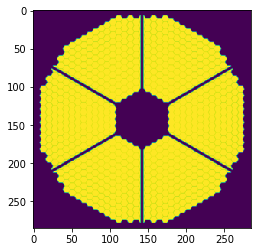

In [10]:
t0 = time.time()
pupil = fits.getdata('/Users/cdelacroix/heeps_metis/input_files/pupil/ELT_fullM1.fits')
#pupil = fits.getdata('~/heeps_metis/input_files/pupil/ELT_fullM1.fits')
pupil_res = resize_img(pupil, npupil)
plt.imshow(pupil_res)
print('duration (s) = %s'%(time.time() - t0))

# Resize with scipy (Gilles' alternative method)

In [11]:
data_gox_petals = petals_res*zoomWithMissingData(data, [npupil,npupil], method='nearest', non_valid_value=np.nan)
masked_petals = np.array([data_gox_petals[x][data_gox_petals[x]!=0] for x in range(npetals)])
for petal in masked_petals:
    print('petal piston (nm) = %s ; petal rms (nm) = %s'%(np.mean(petal), np.std(petal)))
data_gox_petals.shape

petal piston (nm) = 21.739162 ; petal rms (nm) = 118.2782
petal piston (nm) = 8.175823 ; petal rms (nm) = 113.051285
petal piston (nm) = -20.312895 ; petal rms (nm) = 114.32351
petal piston (nm) = 5.8650613 ; petal rms (nm) = 115.26579
petal piston (nm) = -29.29221 ; petal rms (nm) = 117.25961
petal piston (nm) = 15.025115 ; petal rms (nm) = 116.10016


(6, 285, 285)

### visualize resized pupil with this method

duration (s) = 4.942724227905273


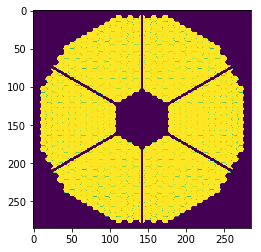

In [12]:
t0 = time.time()
pupil_gox = zoomWithMissingData(pupil, [npupil,npupil], method='nearest', non_valid_value=np.nan)
plt.imshow(pupil_gox)
print('duration (s) = %s'%(time.time() - t0))

# PSD functions

In [13]:
def calc_one_cpp(data, nimg, cpp, verbose=False):
    _, LSF, HSF = spatial(data, conv_kernel(nimg, cpp), verbose=False)
    return LSF, HSF

In [14]:
def calc_multi_cpp(data, nimg, case, cpps, cpu_count=None, verbose=False):
    filename = '%s_%s.fits'
    if not os.path.isfile(filename%('LSFs', case)):
        filename = os.path.join(folder, filename)
    try:
        LSFs = fits.getdata(filename%('LSFs', case))
        HSFs = fits.getdata(filename%('HSFs', case))
        print('   Load LSFs from %s'%filename%('LSFs', case))
        print('   Load HSFs from %s'%filename%('HSFs', case))
    except FileNotFoundError: # run simulation
        (LSFs, HSFs) = multiCPU(calc_one_cpp, posargs=[data, nimg], posvars=[cpps], \
            kwargs=dict(verbose=verbose))
        fits.writeto(filename%('LSFs', case), np.float32(LSFs), overwrite=True)
        fits.writeto(filename%('HSFs', case), np.float32(HSFs), overwrite=True)
    LSFs_rms = np.array([np.std(x[x!=0]) for x in LSFs])
    HSFs_rms = np.array([np.std(x[x!=0]) for x in HSFs])
    dcpp = np.append(cpps[0], cpps[1:] - cpps[:-1])
    drms = np.append(LSFs_rms[0], LSFs_rms[1:] - LSFs_rms[:-1])
    PSD = drms**2/dcpp
    print('LSF (nm rms) = %s'%np.round(LSFs_rms, 2))
    print('HSF (nm rms) = %s'%np.round(HSFs_rms, 2))
    print('PSD = %s'%np.round(PSD, 2))
    return PSD

### raw frame PSD

In [15]:
#cpps = np.logspace(0, 1.1, 3)
cpps = np.logspace(0, 1.6, 40)
data_raw = data_petals[0][nimg//4:nimg//4*3, nimg//2:]
#data_raw = data
print('data_raw.shape = (%s, %s)'%data_raw.shape)
PSD_raw = calc_multi_cpp(data_raw, 720, 'raw', cpps, cpu_count=None, verbose=True)

data_raw.shape = (360, 360)
   Load LSFs from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30/LSFs_raw.fits
   Load HSFs from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30/HSFs_raw.fits
LSF (nm rms) = [ 5.96  6.98  7.88  8.8   9.74 10.69 11.62 12.56 13.37 14.19 14.96 15.68
 16.47 17.18 17.95 18.6  19.29 19.92 20.59 21.2  21.75 22.33 22.82 23.49
 23.92 24.52 25.   25.34 25.88 26.27 26.69 27.16 27.68 28.39 28.87 29.4
 29.95 30.92 31.47 31.47]
HSF (nm rms) = [116.58 116.44 116.34 116.25 116.19 116.13 116.03 115.91 115.77 115.62
 115.47 115.35 115.22 115.1  114.99 114.91 114.79 114.68 114.56 114.45
 114.35 114.24 114.21 114.07 113.9  113.8  113.99 114.09 113.9  113.43
 112.78 112.34 112.67 114.03 115.   115.99 116.84 117.03 115.71 115.71]
PSD = [35.52 10.52  7.51  6.98  6.8   6.13  5.53  5.04  3.41  3.22  2.55  2.02
  2.21  1.64  1.77  1.15  1.16  0.89  0.91  0.69  0.5   0.52  0.34  0.56
  0.21 

### resized frame PSD (skimage)

In [16]:
data_skimg = data_res_petals[0][npupil//4:npupil//4*3, npupil//2:]
#data_skimg = resize_img(data, npupil)
print('data_skimg.shape = (%s, %s)'%data_skimg.shape)
PSD_skimg = calc_multi_cpp(data_skimg, 285, 'skimg', cpps, cpu_count=None, verbose=True)

data_skimg.shape = (142, 143)
   Load LSFs from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30/LSFs_skimg.fits
   Load HSFs from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30/HSFs_skimg.fits
LSF (nm rms) = [ 5.57  6.51  7.4   8.2   9.1  10.02 10.91 11.72 12.55 13.28 13.93 14.63
 15.4  16.08 16.82 17.41 18.03 18.68 19.13 19.85 20.36 20.9  21.48 21.78
 22.43 22.77 23.13 23.51 23.92 24.36 24.87 25.42 26.09 26.09 27.08 27.08
 28.23 28.23 29.76 29.76]
HSF (nm rms) = [92.69 92.54 92.43 92.34 92.27 92.2  92.1  91.98 91.8  91.65 91.51 91.37
 91.21 91.09 90.96 90.88 90.76 90.64 90.54 90.39 90.28 90.16 90.1  90.01
 89.73 89.67 89.76 89.89 89.8  89.32 88.57 88.2  89.11 89.11 91.3  91.3
 92.69 92.69 89.25 89.25]
PSD = [31.05  8.82  7.24  5.42  6.19  5.82  4.94  3.77  3.58  2.53  1.82  1.93
  2.13  1.51  1.62  0.94  0.93  0.94  0.41  0.94  0.43  0.45  0.47  0.12
  0.48  0.13  0.12  0.12  0.13  0.14  0.1

### resized frame PSD (scipy)

In [17]:
data_gox = data_gox_petals[0][npupil//4:npupil//4*3, npupil//2:]
#data_gox = zoomWithMissingData(data, [npupil,npupil], method='nearest', non_valid_value=np.nan)
print('data_gox.shape = (%s, %s)'%data_gox.shape)
PSD_gox = calc_multi_cpp(data_gox, 285, 'gox', cpps, cpu_count=None, verbose=True)

data_gox.shape = (142, 143)
   Load LSFs from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30/LSFs_gox.fits
   Load HSFs from /Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/scao_petal_piston/cbasic_v1_2020-11-30/HSFs_gox.fits
LSF (nm rms) = [ 5.86  6.87  7.81  8.67  9.63 10.62 11.59 12.48 13.4  14.2  14.89 15.64
 16.46 17.16 17.94 18.56 19.22 19.92 20.41 21.21 21.79 22.41 23.09 23.44
 24.21 24.61 25.04 25.48 25.95 26.44 27.   27.63 28.43 28.43 29.65 29.65
 31.08 31.08 32.94 32.94]
HSF (nm rms) = [116.87 116.72 116.62 116.53 116.47 116.4  116.31 116.2  116.04 115.9
 115.77 115.65 115.51 115.39 115.27 115.18 115.07 114.94 114.84 114.69
 114.57 114.45 114.41 114.34 114.08 114.02 114.12 114.26 114.19 113.72
 112.97 112.55 113.41 113.41 115.54 115.54 116.94 116.94 113.61 113.61]
PSD = [34.39 10.2   8.16  6.16  7.05  6.75  5.88  4.6   4.38  3.    2.08  2.19
  2.39  1.63  1.79  1.04  1.06  1.08  0.49  1.16  0.56  0.59  0.63  0.16
  0.67 

# PSD figure

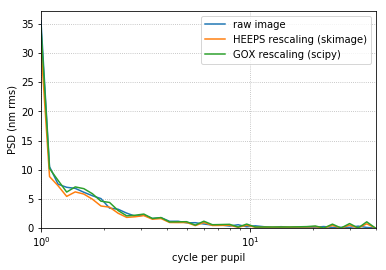

In [18]:
plt.plot(cpps, PSD_raw, label='raw image')
plt.plot(cpps, PSD_skimg, label='HEEPS rescaling (skimage)')
plt.plot(cpps, PSD_gox, label='GOX rescaling (scipy)')
plt.xscale('log')
plt.xlabel('cycle per pupil'), plt.ylabel('PSD (nm rms)')
plt.xlim(1,40), plt.ylim(bottom=0), plt.legend()
plt.grid(True, linestyle=':')
plt.savefig(os.path.join(folder, 'petal_PSD.png'), dpi=300, transparent=True);